### INTRODUÇÃO

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings("ignore")

# Splits / resampling
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    LeaveOneOut,
    cross_val_score,
    cross_validate
)

# Metrics
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    accuracy_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

# Models
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

# Feature selection
from sklearn.feature_selection import f_classif

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils import resample  # for bootstrap

# Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Reproducibility
rng = np.random.default_rng(42)
pd.set_option("display.max_columns", 200)


In [2]:
df = pd.read_csv("dataset.csv")

display(df.head())

df.info()
print("Shape:", df.shape, "| Duplicates:", df.duplicated().sum())

# Basic splits
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

print("Numeric columns:", len(num_cols))
print("Categorical columns:", cat_cols)

# Check class balance (important for classification task)
print("Class distribution:")
print(df['target_class'].value_counts())


,duration_1,duration_2,duration_3,duration_4,duration_5,loudness_level,popularity_level,tempo_class,time_signature,key_mode,artist_song_count,album_freq,movement_index,intensity_level,verbal_density,purity_score,positivity_index,activity_rate,loudness_intensity,happy_dance,acoustics_instrumental,artists_avg_popularity,tempo_vs_genre,energy_rank_pct,loud_energy_ratio,mood_pca,mood_cluster,acoustic_valence_mood_cluster,explicit,signal_strength,mode_indicator,focus_factor,ambient_level,key_sin,key_cos,duration_log,duration_log_z,time_signature_class_boolean,loudness_yeo,is_instrumental,is_dance_hit,temp_zscore,resonance_factor,timbre_index,echo_constant,distorted_movement,signal_power,target_class,target_regression
0,0.0,0.0,0.0,1.0,0.0,2.0,4.0,2.0,0.221824,-1.511882,3.055348,0.465097,-0.592367,-0.215943,-0.558508,-0.538032,0.019031,-1.821983,0.231595,-0.342805,-0.291004,1.174469,-2.050394,-1.035640,-0.009063,-0.526052,-0.107785,1.384717,0.0,0.417,0.0,0.022,0.0974,0.000000e+00,1.000000,1.402643,-0.418639,1.0,-0.462119,0.0,0.0,-1.821975,-0.875781,0.516169,1,-0.517458,0.417,class_93,2.634456
1,0.0,0.0,1.0,0.0,0.0,3.0,4.0,1.0,0.221824,1.330170,0.747117,-0.088815,0.260452,1.083433,-0.482845,-0.798166,-0.293396,0.063556,1.096193,-0.235202,-0.301833,2.232929,-0.079104,0.618424,-0.009369,0.171172,-0.775793,0.396063,0.0,0.807,1.0,0.0177,0.1010,-8.660254e-01,0.500000,1.610770,0.299746,1.0,1.547522,0.0,0.0,0.063556,0.434668,0.085216,1,0.352649,0.807,class_93,2.679289
2,0.0,0.0,0.0,1.0,0.0,0.0,4.0,1.0,0.221824,-1.483743,3.752626,-0.429684,0.790583,0.463670,-0.351381,-0.698623,1.353599,0.595310,-0.206955,1.466782,-0.306003,-0.124485,0.476833,0.562618,-0.009394,1.333943,1.562236,0.725614,0.0,0.797,1.0,0.000745,0.0546,0.000000e+00,1.000000,1.245523,-0.960967,1.0,0.359507,0.0,0.0,0.595308,-0.193942,0.135326,1,-0.788285,0.797,class_93,2.813789
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.221824,0.204605,-0.406998,-0.387075,1.228517,0.147723,0.004234,0.421307,1.210885,0.062022,0.464803,1.637574,-0.305989,1.480086,-0.080708,-0.903516,-0.009104,0.686433,-0.775793,-1.251692,0.0,0.460,1.0,0.000141,0.0610,1.224647e-16,-1.000000,1.756630,0.803206,1.0,-0.061056,0.0,0.0,0.062022,0.784308,0.265456,1,0.197067,0.460,class_93,1.648124
4,0.0,0.0,1.0,0.0,0.0,1.0,4.0,1.0,0.221824,1.583423,-0.238689,-0.472292,0.600427,0.262052,-0.380700,-0.501944,0.076888,-0.006161,-0.179153,0.208423,-0.306278,-1.136754,-0.151992,-0.056277,-0.009326,0.225546,1.228232,1.384717,0.0,0.673,0.0,5.29e-05,0.3040,-5.000000e-01,0.866025,1.601809,0.268814,1.0,0.081898,0.0,0.0,-0.006161,-1.300966,0.629706,1,0.174018,0.673,class_93,2.320623


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   duration_1                     3000 non-null   float64
 1   duration_2                     3000 non-null   float64
 2   duration_3                     3000 non-null   float64
 3   duration_4                     3000 non-null   float64
 4   duration_5                     3000 non-null   float64
 5   loudness_level                 3000 non-null   float64
 6   popularity_level               3000 non-null   float64
 7   tempo_class                    3000 non-null   float64
 8   time_signature                 3000 non-null   float64
 9   key_mode                       3000 non-null   float64
 10  artist_song_count              3000 non-null   float64
 11  album_freq                     3000 non-null   float64
 12  movement_index                 3000 non-null   f

### DATA CLEANING

In [3]:
# Start a modeling copy (will be used later for regression/classification)
df_model = df.copy()

# Outlier winsorization per class, per numeric feature (except targets)
num_features = [
    c for c in df_model.select_dtypes(include=[np.number]).columns
    if c not in ['target_regression']
]

for feature in num_features:
    for cls in df_model['target_class'].unique():
        subset = df_model[df_model['target_class'] == cls][feature]

        Q1 = subset.quantile(0.25)
        Q3 = subset.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        mask = df_model['target_class'] == cls
        df_model.loc[mask, feature] = np.clip(
            df_model.loc[mask, feature],
            lower,
            upper
        )

print("df_model shape after winsorization:", df_model.shape)


df_model shape after winsorization: (3000, 49)


Numeric summary:


,count,mean,std,min,25%,50%,75%,max
duration_1,3000.0,0.098667,0.298264,0.0,0.0,0.0,0.0,1.0
duration_2,3000.0,0.180000,0.384252,0.0,0.0,0.0,0.0,1.0
duration_3,3000.0,0.298667,0.457750,0.0,0.0,0.0,1.0,1.0
duration_4,3000.0,0.376000,0.484461,0.0,0.0,0.0,1.0,1.0
duration_5,3000.0,0.046667,0.210959,0.0,0.0,0.0,0.0,1.0


Categorical summary:


,count,unique,top,freq
focus_factor,3000,1221,0.0,982
target_class,3000,3,class_93,1000


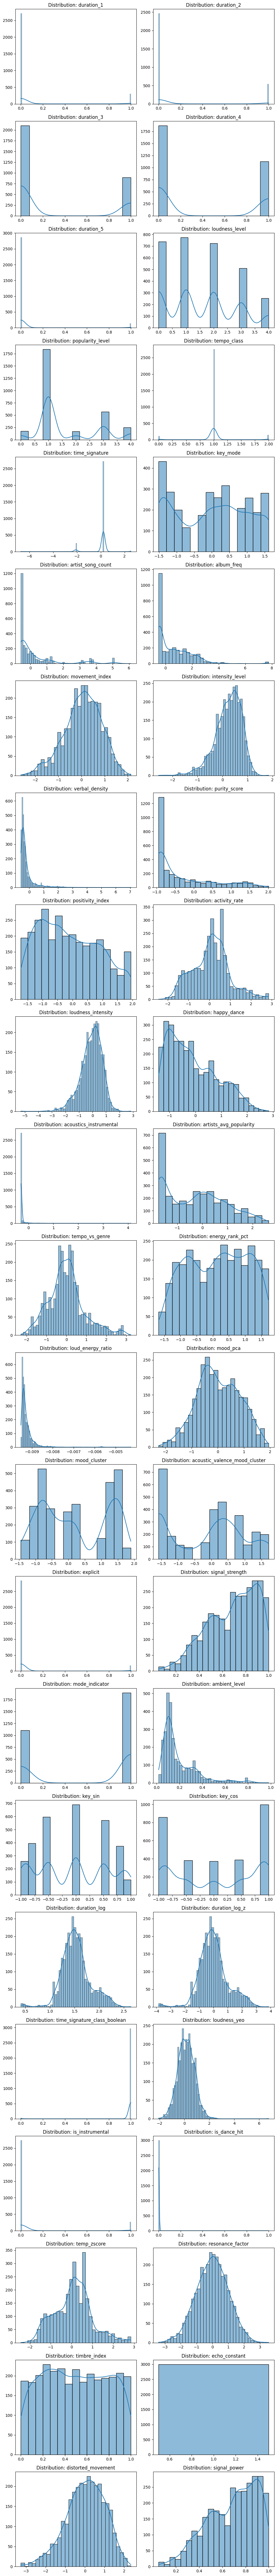

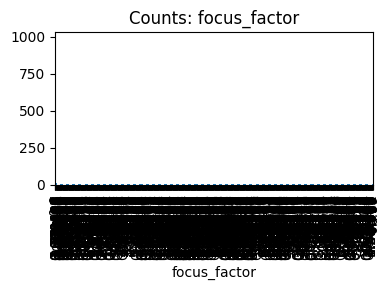

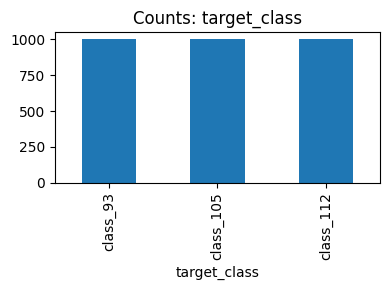

In [4]:
# Descriptive statistics (raw df)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

desc_num = df[num_cols].describe().T
desc_cat = df[cat_cols].describe().T

print("Numeric summary:")
display(desc_num.head())

print("Categorical summary:")
display(desc_cat)

# === Numeric distributions ===
num_features = [c for c in num_cols if c != 'target_regression']

n_cols = 2
n_rows = math.ceil(len(num_features) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_features):
    sns.histplot(df[col].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution: {col}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Remove empty subplots if any
for j in range(len(num_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# === Categorical distributions ===
for col in cat_cols:
    plt.figure(figsize=(4,3))
    df[col].value_counts(dropna=False).plot.bar()
    plt.title(f"Counts: {col}")
    plt.tight_layout()
    plt.show()


### UNIVARIATE ANALYSIS

Target Variables Distribution


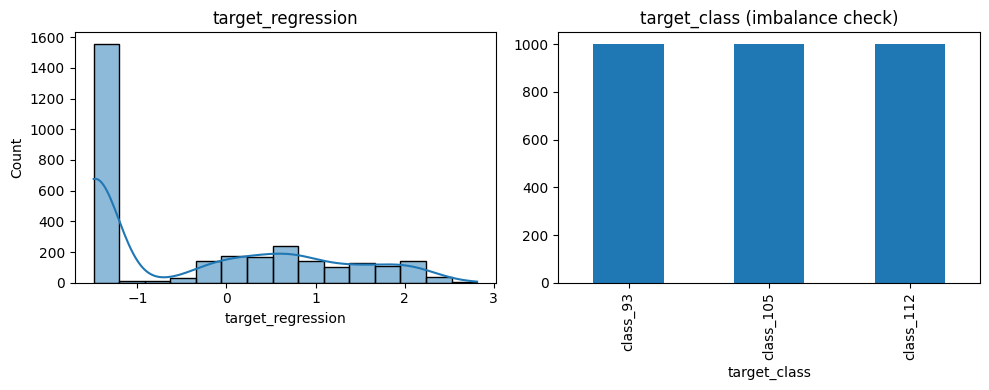

In [5]:
print("Target Variables Distribution")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(df['target_regression'].dropna(), kde=True, ax=axes[0])
axes[0].set_title("target_regression")

df['target_class'].value_counts().plot.bar(ax=axes[1])
axes[1].set_title("target_class (imbalance check)")

plt.tight_layout()
plt.show()


### BIVARIATE ANALYSIS

,Correlação com target_regression
target_regression,1.000000
artists_avg_popularity,0.804786
popularity_level,0.640606
duration_log,0.153175
duration_log_z,0.153175
energy_rank_pct,0.143358
signal_power,0.136441
signal_strength,0.136441
explicit,0.109541
is_instrumental,0.102334


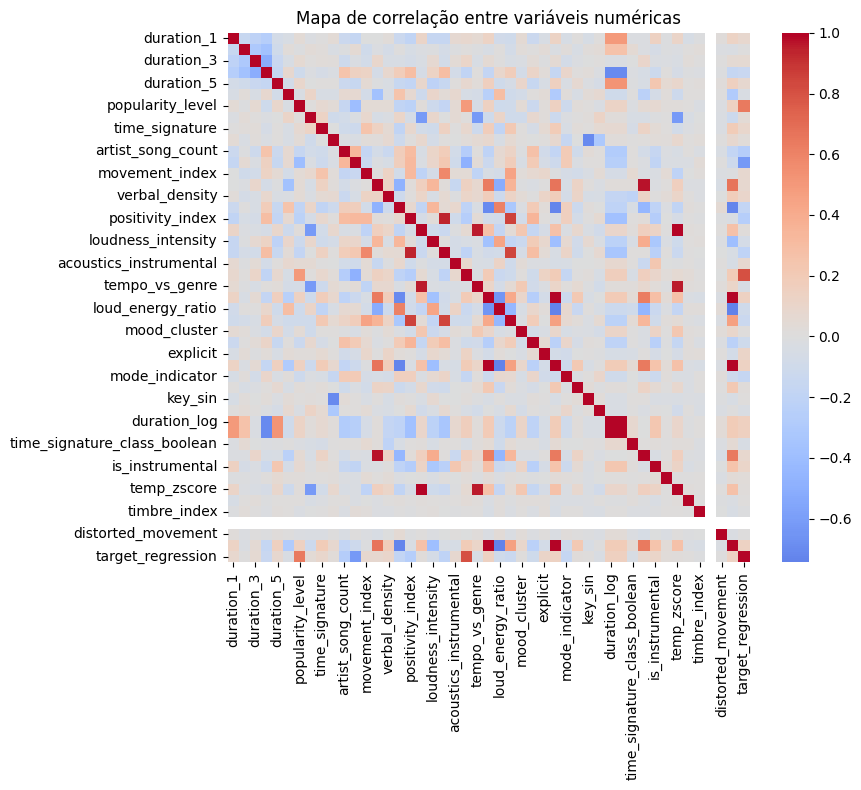

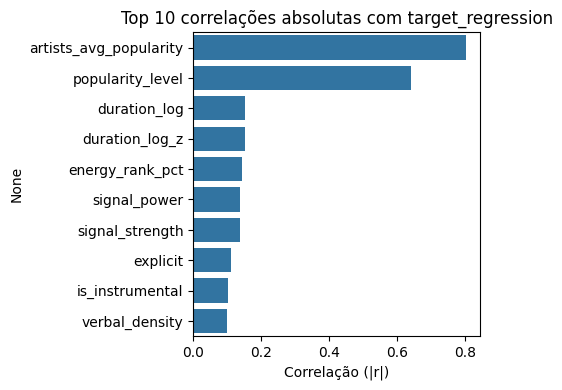

In [6]:
# Compute correlation of all numeric variables with the regression target
corr_matrix = df[num_cols].corr(numeric_only=True)
corr_with_target = corr_matrix['target_regression'].sort_values(ascending=False)

# Display correlation values
display(corr_with_target.to_frame("Correlação com target_regression"))

# Plot heatmap (for overall context)
plt.figure(figsize=(9, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title("Mapa de correlação entre variáveis numéricas")
plt.tight_layout()
plt.show()

# Plot top correlations with regression target
top_corr = corr_with_target.drop('target_regression').abs().head(10)
plt.figure(figsize=(5, 4))
sns.barplot(x=top_corr.values, y=top_corr.index)
plt.title("Top 10 correlações absolutas com target_regression")
plt.xlabel("Correlação (|r|)")
plt.tight_layout()
plt.show()


In [7]:
# Encode class labels numerically for ANOVA
cls_map = {label: i for i, label in enumerate(sorted(df['target_class'].unique()))}
y_class = df['target_class'].map(cls_map)

# Numeric predictors only (exclude regression target)
X_num = df.select_dtypes(include=[np.number]).drop(
    columns=['target_regression'],
    errors='ignore'
)

# ANOVA F-scores per feature for class discrimination
f_vals, p_vals = f_classif(X_num, y_class)

anova_df = pd.DataFrame({
    'Feature': X_num.columns,
    'F_value': f_vals,
    'p_value': p_vals
}).sort_values('F_value', ascending=False)

display(anova_df.head(10))


,Feature,F_value,p_value
23,energy_rank_pct,907.456210,7.277622e-309
29,signal_strength,831.128531,6.959070e-288
45,signal_power,831.128531,6.959070e-288
15,purity_score,690.694594,2.020746e-247
16,positivity_index,407.010163,4.214526e-157
11,album_freq,391.311379,1.019938e-151
38,is_instrumental,310.592061,2.611109e-123
24,loud_energy_ratio,268.380145,6.050774e-108
27,acoustic_valence_mood_cluster,265.502511,6.959630e-107
19,happy_dance,256.422277,1.589250e-103


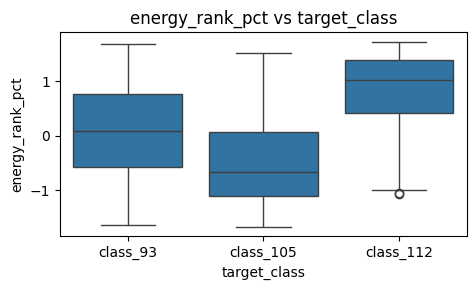

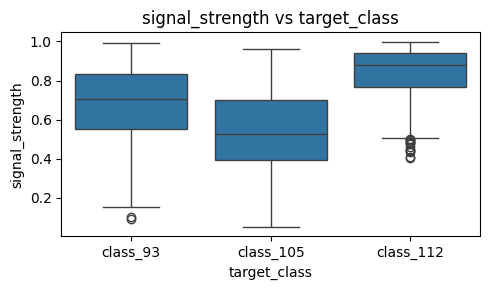

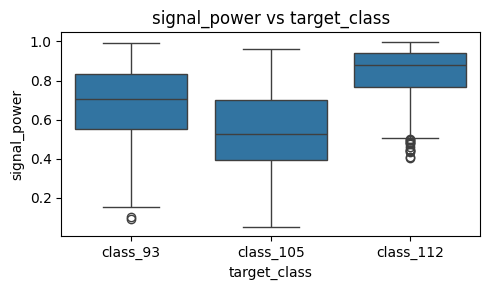

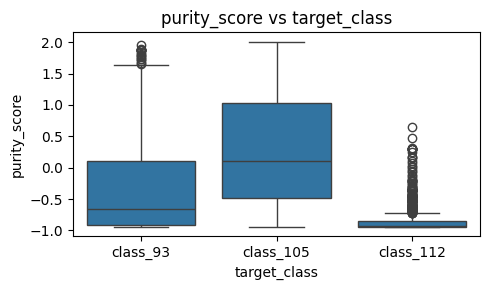

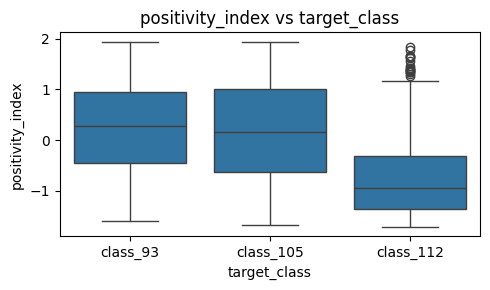

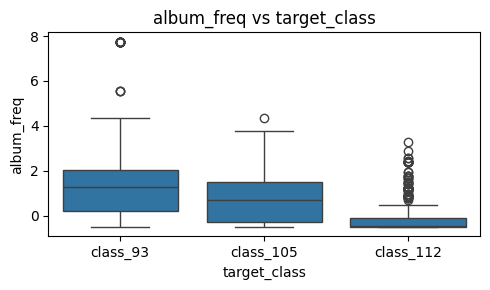

In [8]:
top_features = anova_df['Feature'].head(6).tolist()

for feature in top_features:
    plt.figure(figsize=(5, 3))
    sns.boxplot(x='target_class', y=feature, data=df)
    plt.title(f"{feature} vs target_class")
    plt.tight_layout()
    plt.show()


In [9]:
outlier_info_target = []

for feature in top_features:
    for cls in df['target_class'].unique():
        # Subconjunto da classe atual
        subset = df[df['target_class'] == cls][feature]

        # Quartis e IQR
        Q1 = subset.quantile(0.25)
        Q3 = subset.quantile(0.75)
        IQR = Q3 - Q1

        # Limites inferior e superior
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Contar outliers
        outliers = subset[(subset < lower_bound) | (subset > upper_bound)]
        perc_outliers = len(outliers) / len(subset) * 100

        outlier_info_target.append({
            "Feature": feature,
            "Classe": cls,
            "Nº Outliers": len(outliers),
            "Percentagem (%)": round(perc_outliers, 2)
        })

# Criar DataFrame
outlier_by_class_df = pd.DataFrame(outlier_info_target)

# Pivotar para visualização (features nas linhas, classes nas colunas)
outlier_summary = outlier_by_class_df.pivot(index="Feature", columns="Classe", values="Percentagem (%)")

# Mostrar tabela com gradiente azul
display(outlier_summary.style.background_gradient(cmap="Blues").format("{:.2f} %"))


Classe,class_105,class_112,class_93
Feature,,,
album_freq,0.10 %,12.90 %,2.50 %
energy_rank_pct,0.00 %,0.20 %,0.00 %
positivity_index,0.00 %,1.70 %,0.00 %
purity_score,0.00 %,13.70 %,1.80 %
signal_power,0.00 %,1.40 %,0.20 %
signal_strength,0.00 %,1.40 %,0.20 %


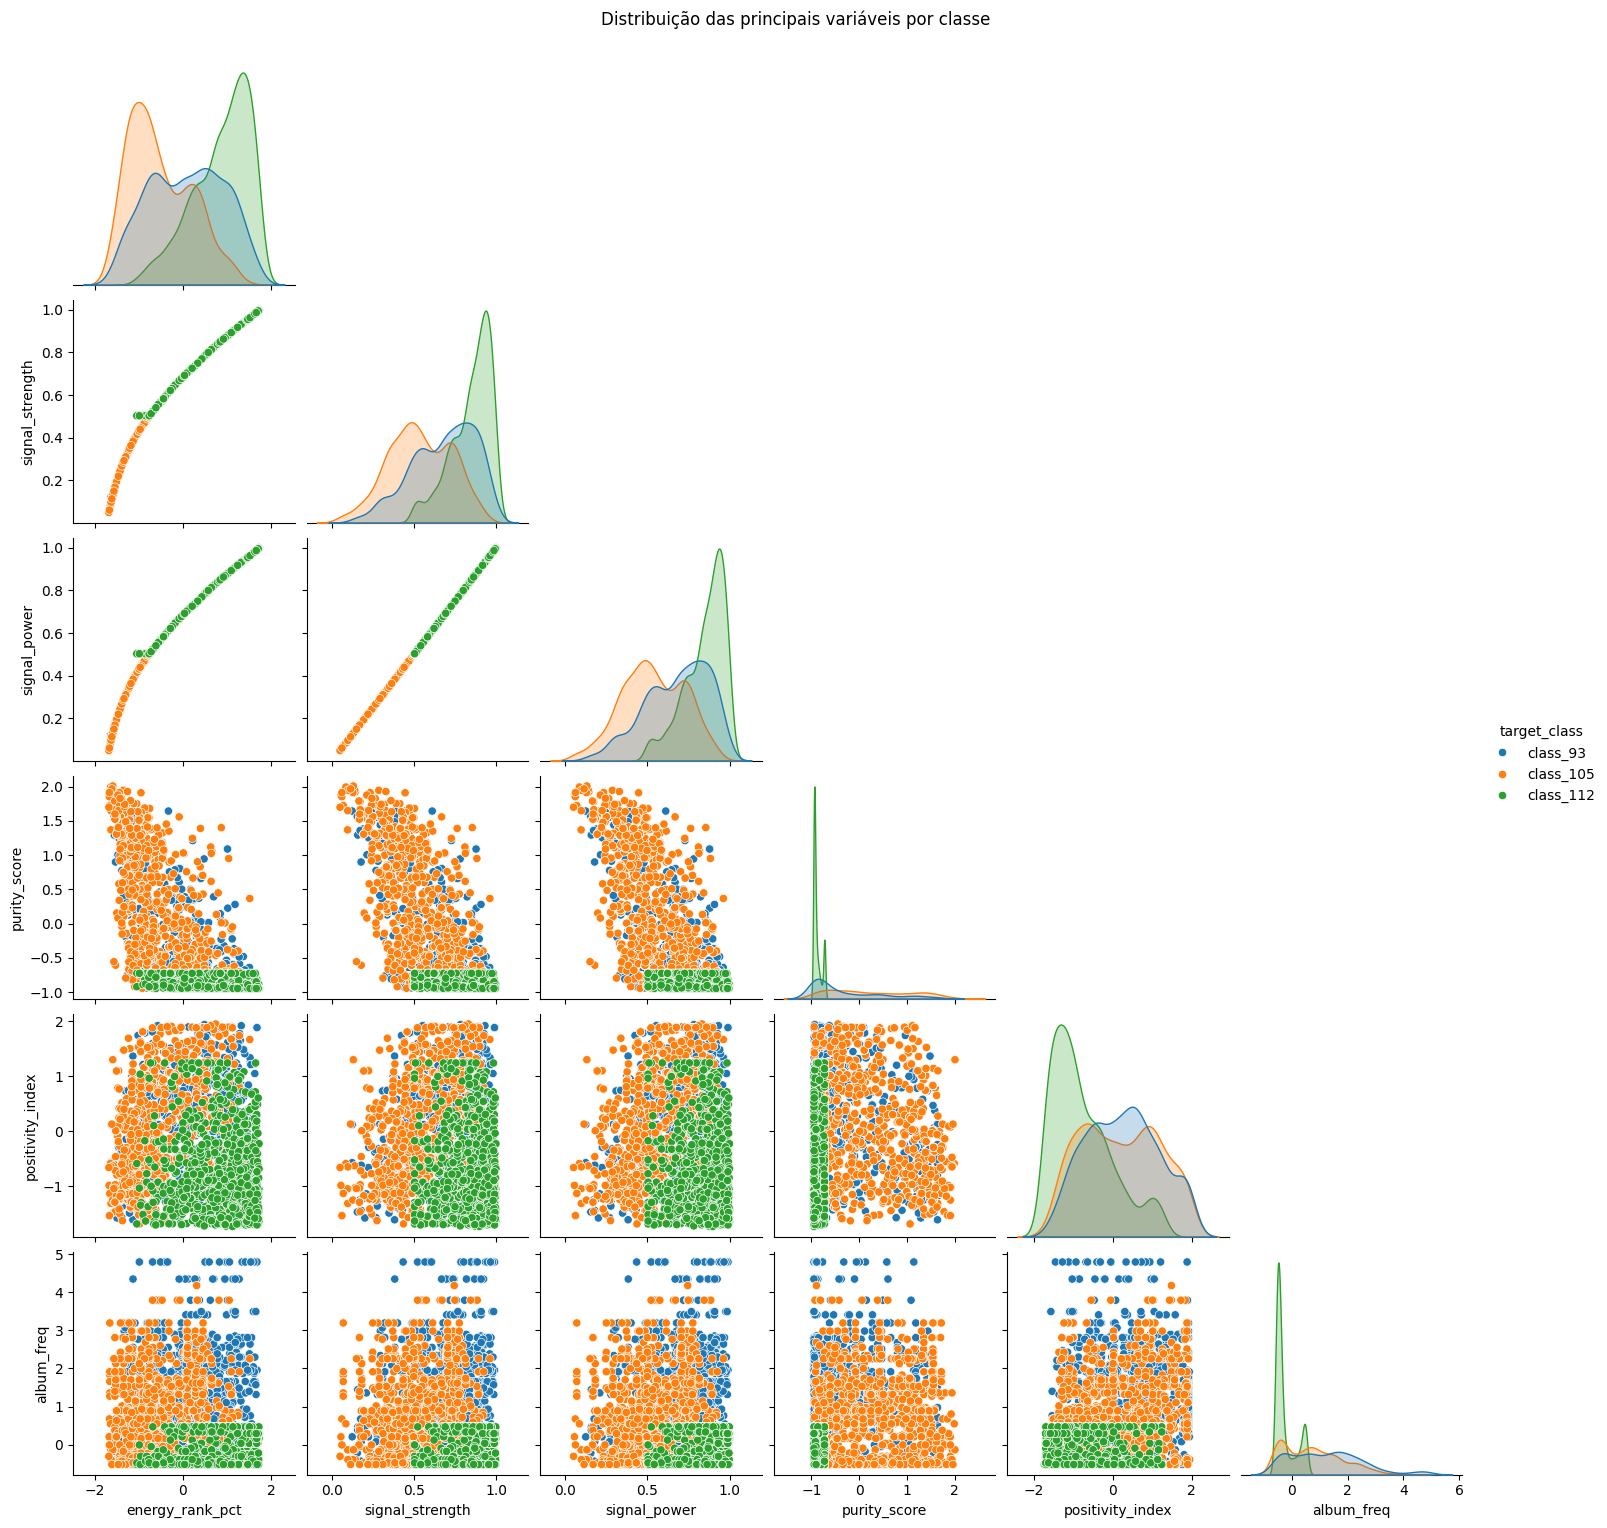

In [10]:
sns.pairplot(
    df_model,
    vars=top_features[:6],
    hue='target_class',
    corner=True
)
plt.suptitle("Distribuição das principais variáveis por classe", y=1.02)
plt.show()


### Multicollinearity Analysis

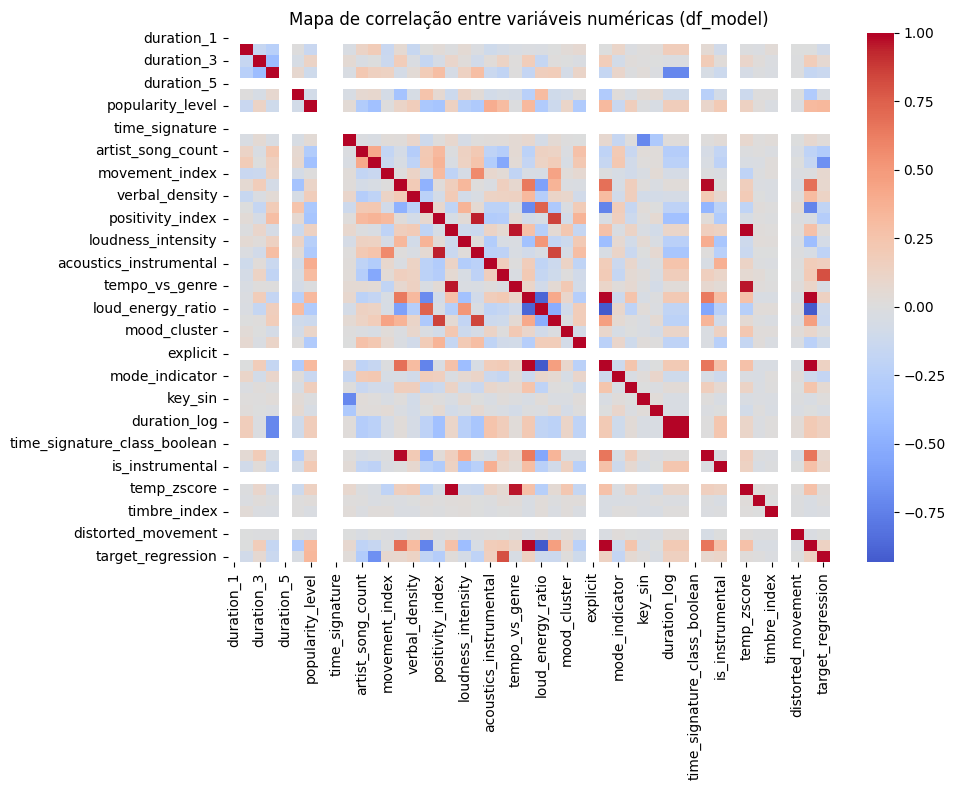

In [11]:
num_cols_model = df_model.select_dtypes(include=[np.number]).columns.tolist()
corr = df_model[num_cols_model].corr(numeric_only=True)

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Mapa de correlação entre variáveis numéricas (df_model)")
plt.tight_layout()
plt.show()


In [12]:
high_corr_pairs = (
    corr.abs()
    .unstack()
    .reset_index()
    .rename(columns={'level_0':'Feature_1','level_1':'Feature_2',0:'Correlation'})
    .query("Feature_1 != Feature_2 and Correlation > 0.8")
    .sort_values(by='Correlation', ascending=False)
)
high_corr_pairs = high_corr_pairs[
    high_corr_pairs.apply(lambda x: x['Feature_1'] < x['Feature_2'], axis=1)
].reset_index(drop=True)

display(high_corr_pairs)


,Feature_1,Feature_2,Correlation
0,duration_log,duration_log_z,1.000000
1,activity_rate,temp_zscore,1.000000
2,signal_power,signal_strength,1.000000
3,energy_rank_pct,signal_strength,0.986471
4,energy_rank_pct,signal_power,0.986471
5,intensity_level,loudness_yeo,0.984292
6,activity_rate,tempo_vs_genre,0.956239
7,temp_zscore,tempo_vs_genre,0.956239
8,happy_dance,positivity_index,0.940358
9,loud_energy_ratio,signal_strength,0.933726


In [13]:
X_vif = (
    df_model
    .select_dtypes(include=[np.number])
    .drop(columns=['target_regression'], errors='ignore')
    .fillna(0)
)

X_vif_const = add_constant(X_vif)

vif_data = pd.DataFrame({
    "Feature": X_vif_const.columns,
    "VIF": [
        variance_inflation_factor(X_vif_const.values, i)
        for i in range(X_vif_const.shape[1])
    ]
})

# Remove constant and sort
vif_data = vif_data[vif_data["Feature"] != "const"].sort_values("VIF", ascending=False)
display(vif_data.head(20))


,Feature,VIF
35,duration_log_z,inf
17,activity_rate,inf
45,signal_power,inf
34,duration_log,inf
29,signal_strength,inf
40,temp_zscore,inf
25,mood_pca,3802.387023
16,positivity_index,2549.714490
23,energy_rank_pct,285.637569
12,movement_index,143.615083


In [14]:
to_drop = [
    # duration & derived variables (highly redundant between them)
    'duration_1','duration_2','duration_3','duration_4','duration_5','duration_log_z',
    # strong collinearity / standardised versions
    'temp_zscore','activity_rate','movement_index','positivity_index','mood_pca',
    # redundant energy/signal style metrics
    'signal_power','energy_rank_pct','loudness_yeo','happy_dance'
]

df_clean = df_model.drop(columns=[c for c in to_drop if c in df_model.columns]).copy()

print("Remaining columns:", df_clean.shape[1])
print("Dropped:", len([c for c in to_drop if c in df_model.columns]), "columns")


Remaining columns: 34
Dropped: 15 columns


In [15]:
# Get numeric columns safely
num_cols_clean = df_clean.select_dtypes(include=[np.number]).columns.tolist()

X_vif2 = (
    df_clean[num_cols_clean]
    .drop(columns=['target_regression'], errors='ignore')
    .fillna(0)
)

X_vif2_const = add_constant(X_vif2)

vif_df2 = pd.DataFrame({
    'Feature': X_vif2_const.columns,
    'VIF': [
        variance_inflation_factor(X_vif2_const.values, i)
        for i in range(X_vif2_const.shape[1])
    ]
})

# Remove the constant term and sort
vif_df2 = vif_df2[vif_df2['Feature'] != 'const'].sort_values('VIF', ascending=False)
display(vif_df2.head(15))


,Feature,VIF
7,intensity_level,16.163435
18,signal_strength,14.933525
14,loud_energy_ratio,14.086774
10,loudness_intensity,11.732768
4,key_mode,2.595319
9,purity_score,2.502155
21,key_sin,2.287514
6,album_freq,1.765356
0,loudness_level,1.573924
1,popularity_level,1.501698


### Regression Modeling

In [16]:
# Separate predictors (numerical only) and regression target
features_reg = [
    c for c in df_clean.columns
    if c not in ['target_regression', 'target_class', 'focus_factor']
]

X = df_clean[features_reg].select_dtypes(include=[np.number]).copy()
y = df_clean['target_regression'].astype(float).copy()

# Train/test split (Holdout)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Impute missing numeric values (if any)
imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=X_train.columns
)
X_test = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns
)


In [17]:
results_simple = []
for col in X.columns:
    lr = LinearRegression()
    lr.fit(X_train[[col]], y_train)
    y_pred = lr.predict(X_test[[col]])
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))   
    results_simple.append((col, r2, mae, rmse))

simple_df = pd.DataFrame(results_simple, columns=['Feature','R2','MAE','RMSE'])
simple_df = simple_df.sort_values('R2', ascending=False)
display(simple_df.head(10))

best_feature = simple_df.iloc[0]['Feature']
print("Best feature for Simple LR:", best_feature)


,Feature,R2,MAE,RMSE
12,artists_avg_popularity,0.676296,0.457400,0.724060
6,album_freq,0.461701,0.759602,0.933710
1,popularity_level,0.084257,1.015469,1.217832
5,artist_song_count,0.075577,1.033129,1.223590
19,mode_indicator,0.051067,1.119669,1.239705
9,purity_score,0.036573,1.101622,1.249137
23,duration_log,0.021549,1.130940,1.258839
11,acoustics_instrumental,0.019194,1.132436,1.260353
18,signal_strength,0.015896,1.126565,1.262470
16,acoustic_valence_mood_cluster,0.009389,1.133894,1.266637


Best feature for Simple LR: artists_avg_popularity


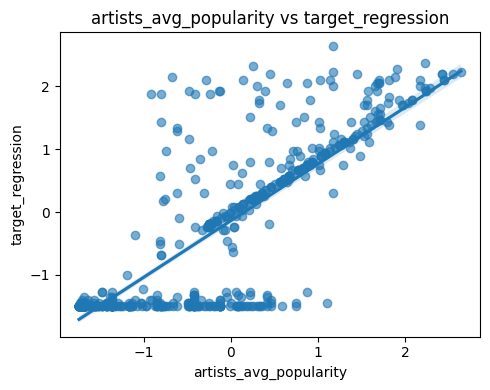

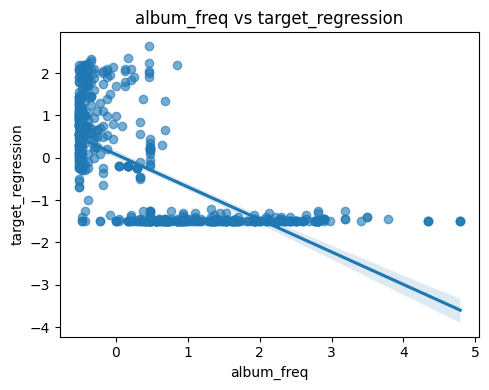

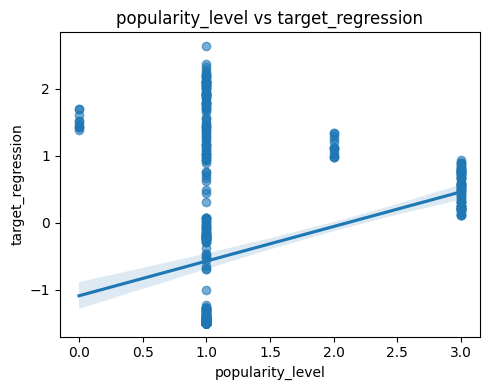

In [18]:
top3 = simple_df.head(3)['Feature'].tolist()

for feat in top3:
    plt.figure(figsize=(5,4))
    sns.regplot(x=X_test[feat], y=y_test, scatter_kws={'alpha':0.6})
    plt.title(f"{feat} vs target_regression")
    plt.xlabel(feat)
    plt.ylabel("target_regression")
    plt.tight_layout()
    plt.show()


### Multiple Linear Regression

In [19]:
# Correlation with regression target
corr_with_y = df_clean.corr(numeric_only=True)['target_regression'].sort_values(ascending=False)
corr_with_y

target_regression                1.000000
artists_avg_popularity           0.804888
popularity_level                 0.328509
acoustics_instrumental           0.158513
duration_log                     0.152945
signal_strength                  0.137288
verbal_density                   0.130489
is_instrumental                  0.106829
intensity_level                  0.083210
ambient_level                    0.056750
key_mode                         0.030032
key_sin                          0.014923
mood_cluster                     0.012707
resonance_factor                 0.007864
distorted_movement               0.002554
timbre_index                    -0.014423
key_cos                         -0.033870
loudness_level                  -0.034294
tempo_vs_genre                  -0.046623
loudness_intensity              -0.067132
acoustic_valence_mood_cluster   -0.109147
loud_energy_ratio               -0.115268
mode_indicator                  -0.171697
purity_score                    -0

In [20]:
# Get top correlated features (excluding the target)
top3 = corr_with_y.drop('target_regression', errors='ignore').abs().head(3).index.tolist()
top5 = corr_with_y.drop('target_regression', errors='ignore').abs().head(5).index.tolist()
top4 = corr_with_y.drop('target_regression', errors='ignore').abs().head(4).index.tolist()
top10 = corr_with_y.drop('target_regression', errors='ignore').abs().head(10).index.tolist()
top5_no4 = [top10[i] for i in [0, 1, 2, 4]]

print("Top 5 features:", top5)
print("Top 10 features:", top10)

Top 5 features: ['artists_avg_popularity', 'popularity_level', 'acoustics_instrumental', 'duration_log', 'signal_strength']
Top 10 features: ['artists_avg_popularity', 'popularity_level', 'acoustics_instrumental', 'duration_log', 'signal_strength', 'verbal_density', 'is_instrumental', 'intensity_level', 'ambient_level', 'key_mode']


In [21]:
def eval_lr(cols, name):
    lr = LinearRegression()
    lr.fit(X_train[cols], y_train)
    y_pred = lr.predict(X_test[cols])
    return {
        'Model': name,
        'R2': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'Features': cols
    
    }

In [22]:
models_reg = [
    eval_lr([best_feature], "best feature"),     # simple model (baseline)
    eval_lr(top3, "top 3"),
    eval_lr(top4, "top 4"),
    eval_lr(top5_no4, "top 5 without 4th feature"),
    eval_lr(top5, "top 5"),
    eval_lr(top10, "top 10"),
    eval_lr(X.columns.tolist(), "all")  # all numeric features
]

reg_results = pd.DataFrame(models_reg).sort_values('R2', ascending=False)
display(reg_results[['Model','R2','MAE','RMSE']])

,Model,R2,MAE,RMSE
6,all,0.753703,0.440693,0.631583
5,top 10,0.687626,0.456594,0.711276
4,top 5,0.686168,0.464437,0.712934
3,top 5 without 4th feature,0.685897,0.464204,0.713242
2,top 4,0.682515,0.465687,0.717071
1,top 3,0.682461,0.465476,0.717132
0,best feature,0.676296,0.457400,0.724060


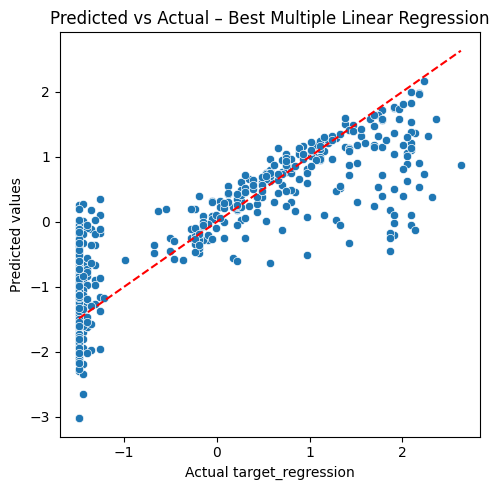

In [23]:
# Use the best-performing model (highest R²)
best_model_features = reg_results.iloc[0]['Features']
lr_best = LinearRegression().fit(X_train[best_model_features], y_train)
y_pred_best = lr_best.predict(X_test[best_model_features])

plt.figure(figsize=(5,5))
sns.scatterplot(x=y_test, y=y_pred_best)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Predicted vs Actual – Best Multiple Linear Regression")
plt.xlabel("Actual target_regression")
plt.ylabel("Predicted values")
plt.tight_layout()
plt.show()


### Classification Modeling

In [24]:
# Ensure target columns exist
if 'target_class' not in df_clean.columns:
    df_clean['target_class'] = df_model['target_class']
if 'target_regression' not in df_clean.columns:
    df_clean['target_regression'] = df_model['target_regression']

# Coerce focus_factor (object) to numeric
df_clean['focus_factor'] = pd.to_numeric(df_clean['focus_factor'], errors='coerce')

# === Classification dataset ===
y_cls = df_clean['target_class']
X_cls = df_clean.drop(columns=['target_class','target_regression'], errors='ignore')

# Ensure all predictors are numeric and fill missing with medians
X_cls = X_cls.select_dtypes(include=np.number).fillna(X_cls.median(numeric_only=True))

print("X_cls shape:", X_cls.shape)
print("y_cls distribution:\n", y_cls.value_counts())

# Split with stratification if all classes have >1 record
if y_cls.value_counts().min() > 1:
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
        X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
    )
else:
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
        X_cls, y_cls, test_size=0.2, random_state=42
    )


X_cls shape: (3000, 32)
y_cls distribution:
 target_class
class_93     1000
class_105    1000
class_112    1000
Name: count, dtype: int64


In [25]:

def evaluate_classifier(model, X_train, X_test, y_train, y_test, rng):
    model_name = type(model).__name__
    print(f"\n============================")
    print(f"📊 Model: {model_name}")
    print("============================\n")

    # --- 1️⃣ Holdout Evaluation ---
    model_fit = model.__class__(**model.get_params())
    model_fit.fit(X_train, y_train)
    preds = model_fit.predict(X_test)
    probs = model_fit.predict_proba(X_test) if hasattr(model_fit, "predict_proba") else None

    holdout_metrics = {
        "Accuracy": accuracy_score(y_test, preds),
        "Recall (macro)": recall_score(y_test, preds, average="macro"),
        "F1 (macro)": f1_score(y_test, preds, average="macro"),
        "ROC AUC (ovr)": roc_auc_score(pd.get_dummies(y_test), probs, multi_class="ovr") if probs is not None else np.nan
    }

    df_holdout = pd.DataFrame(holdout_metrics, index=[model_name])
    print("📍 Holdout Results:")
    display(df_holdout)

    # --- 2️⃣ 5-Fold Cross Validation ---
    skf5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv5 = cross_validate(
        model, X_train, y_train,
        cv=skf5,
        scoring=["accuracy", "recall_macro", "f1_macro"],
        n_jobs=-1
    )

    df_cv5 = pd.DataFrame({
        "Accuracy": [cv5["test_accuracy"].mean()],
        "Recall (macro)": [cv5["test_recall_macro"].mean()],
        "F1 (macro)": [cv5["test_f1_macro"].mean()]
    }, index=[model_name])
    print("\n📍 5-Fold Cross Validation:")
    display(df_cv5)

    # --- 3️⃣ 10-Fold Cross Validation ---
    skf10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv10 = cross_validate(
        model, X_train, y_train,
        cv=skf10,
        scoring=["accuracy", "recall_macro", "f1_macro"],
        n_jobs=-1
    )

    df_cv10 = pd.DataFrame({
        "Accuracy": [cv10["test_accuracy"].mean()],
        "Recall (macro)": [cv10["test_recall_macro"].mean()],
        "F1 (macro)": [cv10["test_f1_macro"].mean()]
    }, index=[model_name])
    print("\n📍 10-Fold Cross Validation:")
    display(df_cv10)

    # --- 4️⃣ Leave-One-Out Cross Validation (LOOCV) ---
    loo = LeaveOneOut()
    cvloo = cross_validate(
        model, X_train, y_train,
        cv=loo,
        scoring=["accuracy", "recall_macro", "f1_macro"]
    )

    df_loocv = pd.DataFrame({
        "Accuracy": [cvloo["test_accuracy"].mean()],
        "Recall (macro)": [cvloo["test_recall_macro"].mean()],
        "F1 (macro)": [cvloo["test_f1_macro"].mean()]
    }, index=[model_name])
    print("\n📍 Leave-One-Out Cross Validation (LOOCV):")
    display(df_loocv)

    # --- 5️⃣ Bootstrap Evaluation ---
    boot_metrics = {"Accuracy": [], "Recall (macro)": [], "F1 (macro)": []}
    for _ in range(100):
        idx = rng.integers(0, len(y_train), len(y_train))
        X_b = X_train.iloc[idx]
        y_b = y_train.iloc[idx]

        m_boot = model.__class__(**model.get_params())
        m_boot.fit(X_b, y_b)
        preds_b = m_boot.predict(X_b)
        boot_metrics["Accuracy"].append(accuracy_score(y_b, preds_b))
        boot_metrics["Recall (macro)"].append(recall_score(y_b, preds_b, average="macro"))
        boot_metrics["F1 (macro)"].append(f1_score(y_b, preds_b, average="macro"))

    df_boot = pd.DataFrame({
        "Accuracy": [np.mean(boot_metrics["Accuracy"])],
        "Recall (macro)": [np.mean(boot_metrics["Recall (macro)"])],
        "F1 (macro)": [np.mean(boot_metrics["F1 (macro)"])]
    }, index=[model_name])
    print("\n📍 Bootstrap Results:")
    display(df_boot)

    # Return all metrics as dict (for storage or summary table)
    return {
        "Model": model_name,
        "Holdout_Accuracy": holdout_metrics["Accuracy"],
        "Holdout_Recall": holdout_metrics["Recall (macro)"],
        "Holdout_F1": holdout_metrics["F1 (macro)"],
        "Holdout_ROC_AUC": holdout_metrics["ROC AUC (ovr)"],
        "CV5_Accuracy": df_cv5["Accuracy"].iloc[0],
        "CV5_Recall": df_cv5["Recall (macro)"].iloc[0],
        "CV5_F1": df_cv5["F1 (macro)"].iloc[0],
        "CV10_Accuracy": df_cv10["Accuracy"].iloc[0],
        "CV10_Recall": df_cv10["Recall (macro)"].iloc[0],
        "CV10_F1": df_cv10["F1 (macro)"].iloc[0],
        "LOOCV_Accuracy": df_loocv["Accuracy"].iloc[0],
        "LOOCV_Recall": df_loocv["Recall (macro)"].iloc[0],
        "LOOCV_F1": df_loocv["F1 (macro)"].iloc[0],
        "Bootstrap_Accuracy": df_boot["Accuracy"].iloc[0],
        "Bootstrap_Recall": df_boot["Recall (macro)"].iloc[0],
        "Bootstrap_F1": df_boot["F1 (macro)"].iloc[0]
    }


In [26]:
models = [
    LogisticRegression(max_iter=500, random_state=42),
    LDA(),
    QDA()
]

results = [
    evaluate_classifier(m, X_train_c, X_test_c, y_train_c, y_test_c, rng)
    for m in models
]



📊 Model: LogisticRegression

📍 Holdout Results:


,Accuracy,Recall (macro),F1 (macro),ROC AUC (ovr)
LogisticRegression,0.785,0.785,0.783119,0.921779



📍 5-Fold Cross Validation:


,Accuracy,Recall (macro),F1 (macro)
LogisticRegression,0.804583,0.804583,0.803666



📍 10-Fold Cross Validation:


,Accuracy,Recall (macro),F1 (macro)
LogisticRegression,0.80125,0.80125,0.800203



📍 Leave-One-Out Cross Validation (LOOCV):


,Accuracy,Recall (macro),F1 (macro)
LogisticRegression,0.8075,0.8075,0.8075



📍 Bootstrap Results:


,Accuracy,Recall (macro),F1 (macro)
LogisticRegression,0.82125,0.821297,0.820827



📊 Model: LinearDiscriminantAnalysis

📍 Holdout Results:


,Accuracy,Recall (macro),F1 (macro),ROC AUC (ovr)
LinearDiscriminantAnalysis,0.77,0.77,0.774397,0.916267



📍 5-Fold Cross Validation:


,Accuracy,Recall (macro),F1 (macro)
LinearDiscriminantAnalysis,0.792917,0.792917,0.796157



📍 10-Fold Cross Validation:


,Accuracy,Recall (macro),F1 (macro)
LinearDiscriminantAnalysis,0.792917,0.792917,0.79582



📍 Leave-One-Out Cross Validation (LOOCV):


,Accuracy,Recall (macro),F1 (macro)
LinearDiscriminantAnalysis,0.791667,0.791667,0.791667



📍 Bootstrap Results:


,Accuracy,Recall (macro),F1 (macro)
LinearDiscriminantAnalysis,0.805821,0.805607,0.808574



📊 Model: QuadraticDiscriminantAnalysis

📍 Holdout Results:


,Accuracy,Recall (macro),F1 (macro),ROC AUC (ovr)
QuadraticDiscriminantAnalysis,0.703333,0.703333,0.701365,0.869942



📍 5-Fold Cross Validation:


,Accuracy,Recall (macro),F1 (macro)
QuadraticDiscriminantAnalysis,0.715833,0.715833,0.70953



📍 10-Fold Cross Validation:


,Accuracy,Recall (macro),F1 (macro)
QuadraticDiscriminantAnalysis,0.72,0.72,0.715082



📍 Leave-One-Out Cross Validation (LOOCV):


,Accuracy,Recall (macro),F1 (macro)
QuadraticDiscriminantAnalysis,0.70125,0.70125,0.70125



📍 Bootstrap Results:


,Accuracy,Recall (macro),F1 (macro)
QuadraticDiscriminantAnalysis,0.738354,0.738185,0.736805


Alpha: 0.05
R² (teste): 0.7498
MAE (teste): 0.4392
RMSE (teste): 0.6365

=== Features selecionadas pelo LASSO ===


,Feature,Coefficient
12,artists_avg_popularity,0.659703
6,album_freq,-0.348026


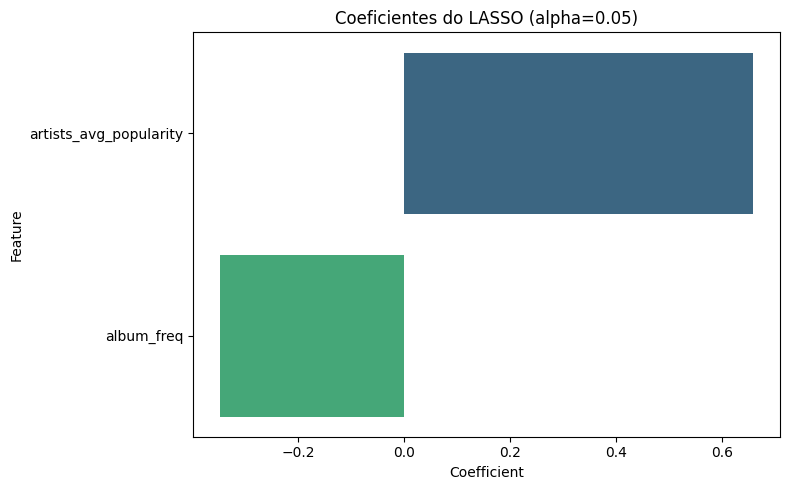

In [27]:
# 2. Aplicar LASSO com alpha manual

# Definir alpha manualmente (ajuste se necessário)
alpha_value = 0.05

lasso = Lasso(alpha=alpha_value, random_state=42)
lasso.fit(X_train, y_train)


# 3. Avaliar desempenho no conjunto de teste

y_pred = lasso.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Alpha: {alpha_value}")
print(f"R² (teste): {r2:.4f}")
print(f"MAE (teste): {mae:.4f}")
print(f"RMSE (teste): {rmse:.4f}")

# ----------------------------------------------------------
# 4. Selecionar features com coeficiente != 0
# ----------------------------------------------------------

coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso.coef_
})
selected_features = coef_df[coef_df['Coefficient'] != 0].sort_values(by='Coefficient', ascending=False)

print("\n=== Features selecionadas pelo LASSO ===")
display(selected_features)

# ----------------------------------------------------------
# 5. Visualização dos coeficientes
# ----------------------------------------------------------

plt.figure(figsize=(8, 5))
sns.barplot(x='Coefficient', y='Feature', data=selected_features, palette='viridis')
plt.title(f'Coeficientes do LASSO (alpha={alpha_value})')
plt.tight_layout()
plt.show()



In [28]:
df_clean['target_regression'].describe()

count    3000.000000
mean       -0.348556
std         1.290190
min        -1.490205
25%        -1.490205
50%        -1.355706
75%         0.706625
max         2.813789
Name: target_regression, dtype: float64

,Modelo,R²,MAE,RMSE,Nº Features
0,Lasso (alpha=0.05),0.749830,0.439216,0.636529,2
1,Linear Regression (todas),0.753703,0.440693,0.631583,31


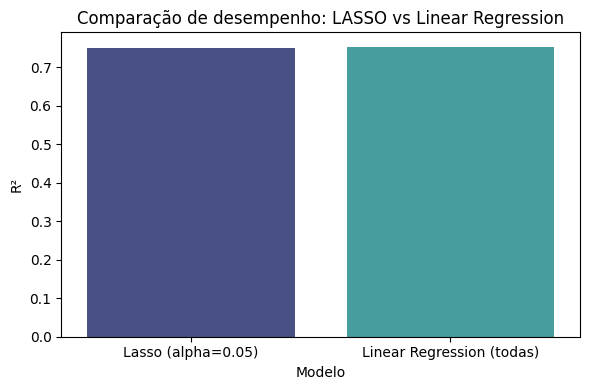

In [29]:
# ----------------------------------------------------------
# 6. Comparação com modelo Linear Regression (todas as features)
# ----------------------------------------------------------

# Modelo linear completo
lr_full = LinearRegression()
lr_full.fit(X_train, y_train)
y_pred_lr = lr_full.predict(X_test)

r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

# Comparação direta
comparison = pd.DataFrame({
    'Modelo': ['Lasso (alpha=0.05)', 'Linear Regression (todas)'],
    'R²': [r2, r2_lr],
    'MAE': [mae, mae_lr],
    'RMSE': [rmse, rmse_lr],
    'Nº Features': [len(selected_features), X.shape[1]]
})

display(comparison)

# Visualização da comparação
plt.figure(figsize=(6,4))
sns.barplot(x='Modelo', y='R²', data=comparison, palette='mako')
plt.title('Comparação de desempenho: LASSO vs Linear Regression')
plt.tight_layout()
plt.show()
